In [1]:
import sqlite3
import pandas as pd
from tqdm import tqdm
import folium
import numpy as np
import os
import wget

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None) 


In [2]:
url = 'https://hitchmap.com/dump.sqlite'
filename = 'dump.sqlite'
if os.path.exists(filename):
        os.remove(filename)
filename = wget.download(url)

In [3]:
fn = 'dump.sqlite'
points = pd.read_sql('select * from points where not banned', sqlite3.connect(fn))
points["datetime"] = points["datetime"].astype("datetime64[ns]")

In [4]:
points.head()

,id,lat,lon,rating,country,wait,nickname,comment,datetime,reviewed,banned,ip,dest_lat,dest_lon,signal,ride_datetime,user_id,from_hitchwiki
0,0,40.974714,27.511654,3.0,TR,NaN,Tamergem,"If you avoid the mini busses, you can get on a ride within 10 minutes, and Tekirdag city is a bridge between Istanbul and Greece. I always use that city center spot and it is quite good",2011-05-26 10:06:17,1,0,,NaN,NaN,None,None,NaN,1.0
1,1,32.072756,34.793444,4.0,IL,NaN,None,None,NaT,1,0,,NaN,NaN,None,None,NaN,NaN
2,2,41.727928,27.220731,4.0,TR,NaN,None,None,NaT,1,0,,NaN,NaN,None,None,NaN,NaN
3,3,41.099858,29.007339,3.0,TR,NaN,Xavierallard,There is a lot of traffic there and little space to stop. I found it hard.,2011-03-15 12:52:11,1,0,,NaN,NaN,None,None,NaN,1.0
4,4,30.169989,66.999612,3.0,PK,NaN,None,None,NaT,1,0,,NaN,NaN,None,None,NaN,NaN


In [5]:
points.info(), 44345/62768

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63123 entries, 0 to 63122
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              63123 non-null  int64         
 1   lat             63123 non-null  float64       
 2   lon             63123 non-null  float64       
 3   rating          63123 non-null  float64       
 4   country         63123 non-null  object        
 5   wait            31914 non-null  float64       
 6   nickname        26679 non-null  object        
 7   comment         44674 non-null  object        
 8   datetime        55883 non-null  datetime64[ns]
 9   reviewed        63123 non-null  int64         
 10  banned          63123 non-null  int64         
 11  ip              63123 non-null  object        
 12  dest_lat        11455 non-null  float64       
 13  dest_lon        11455 non-null  float64       
 14  signal          4826 non-null   object        
 15  ri

(None, 0.7064905684425185)

# activity

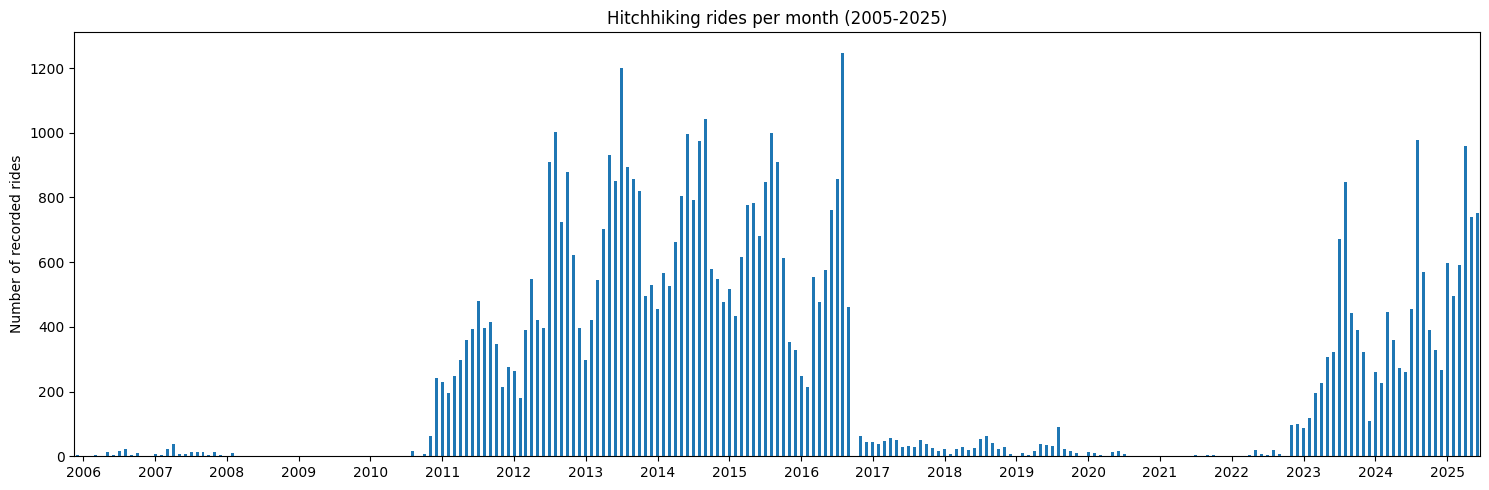

In [21]:
df = points
df["datetime"] = df["datetime"].astype("datetime64[ns]")
df = df[df["datetime"] >= "2005-01-01"]

# Create a complete date range for all months between min and max date
all_months = pd.date_range(df["datetime"].min().replace(day=1), df["datetime"].max().replace(day=1), freq='MS')
all_months_index = pd.MultiIndex.from_arrays([all_months.year, all_months.month])

# Group by year and month, and count
grouped = df["datetime"].groupby([df["datetime"].dt.year, df["datetime"].dt.month]).count()
grouped = grouped.reindex(all_months_index, fill_value=0)

# Only show x-ticks for January of each year
january_idx = [i for i, (y, m) in enumerate(grouped.index) if m == 1]
january_years = [str(y) for (y, m) in grouped.index if m == 1]

plot = grouped.plot(kind="bar", title="Hitchhiking rides per month (2005-2025)", figsize=(15, 5))
plot.set_ylabel("Number of recorded rides")
plot.set_xticks(january_idx)
plot.set_xticklabels(january_years, rotation=0)
plot.figure.tight_layout()
plot.figure.savefig("plots/rides_per_month.png")



In [ ]:
df = points[['datetime', 'wait']].dropna()
df["datetime"] = df["datetime"].astype("datetime64[ns]")

plot = df['datetime'].groupby([df["datetime"].dt.year, df["datetime"].dt.month]).count().plot(kind="bar", title="Points per month with waiting time recorded", figsize=(50, 5))
# plot.figure.savefig("plots/points_per_month_with_waittime.png")

### seasonality


In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt

df = points.copy()
df["datetime"] = df["datetime"].astype("datetime64[ns]")
df["month"] = df["datetime"].dt.month

plt.figure(figsize=(10, 5))
sns.histplot(df["month"], bins=12, discrete=True)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xlabel("Month")
plt.ylabel("Number of rides")
plt.title("Accumulated number of recorded hitchhiking rides by month (2005-2025)")
plt.tight_layout()
plt.savefig("plots/number_of_rides_per_month.png")
plt.show()

# history

In [ ]:
df.head()

In [ ]:
df = points[points["datetime"].isna()]
len(df), len(points)

In [ ]:
df[df["nickname"].notna()]

In [ ]:
df.info()

In [ ]:
df = points.sort_values(by='datetime')
df.head()

In [ ]:
df[df["dest_lat"].notna()].head()

In [ ]:
df[df["signal"].notna()].head(5)

In [ ]:
df[~df["nickname"].isna()].head(1)

In [ ]:
old = points[points["datetime"] < "2010-08-11"].sort_values(by='datetime')
old = old[old["datetime"] > "2005-08-01"]
m = folium.Map(location=[old['lat'].mean(), old['lon'].mean()], zoom_start=2)
for _, row in tqdm(old.iterrows()):
    folium.CircleMarker(location=[row['lat'], row['lon']], radius=2).add_to(m)
m

In [ ]:
# there are multiple people who submitted points before 2010
old[old["datetime"] > "2007-03-28"].head(12)

In [ ]:
df[(df["datetime"] > "2017-01-01") & (df["datetime"] < "2020-05-01")]["nickname"].value_counts()
# no-one adding spots consistntly in this period

In [ ]:
# there are users who kept adding over 2017 but something caused a heavy drop in activity of other users
df[df["nickname"] == "Sitko"].tail()

In [ ]:
df[df["nickname"] == "Thumb-up"].tail()

In [ ]:
df[(df["datetime"] < "2017-01-01") & (df["datetime"] > "2005-05-01")]["nickname"].value_counts()


In [ ]:
groups = points.groupby(["lat", "lon"])
places = groups[["country"]].first()
places["rating"] = groups.rating.mean()
places["points"] = groups.size()

In [ ]:
places['score'] = places['rating']**3 * places['points']
places.sort_values("score", ascending=False).head(5)

In [39]:
df = points[(points.ride_datetime.notna()) & (points.ride_datetime != "")].sort_values(by='ride_datetime')
df.head(100)

,id,lat,lon,rating,country,wait,nickname,comment,datetime,reviewed,banned,ip,dest_lat,dest_lon,signal,ride_datetime,user_id,from_hitchwiki
59251,6654082449690107442,-33.804661,19.872288,1.0,ZA,180.0,None,"ahead Terura loko. Dekoj da homoj alvenas ĉiuminute svingante monon, por ke homoj prenu ilin. Ĉiuj, kiuj haltis al mi, petis monon. Promenu antaŭen .",2025-03-11 12:40:16.005680,0,0,,-33.804661,19.872288,sign,0025-03-07T08:00,221.0,NaN
62554,9068947538444523759,33.213433,-97.155007,5.0,US,5.0,None,"Was at a pretty good spot to pull over on North Texas, and started walking and hitching before a dude walking behind me offered me a ride, so I walked w him to his car. Gave me a ride to University. Pedestrians give a lot of rides in Denton",2025-04-04 19:51:51.279370,0,0,,33.229447,-97.153248,thumb,0202-04-03T18:50,255.0,NaN
54075,2937316318010967392,-5.095939,30.379922,4.0,TZ,35.0,None,"Mi alvenis nokte kaj volis daŭrigi la vojaĝon, ne estis lumo, la vojo estas tera, sed multaj kamionoj tamen eniras. Estas polica haltejo antaŭe, do ĉiuj eniras malrapide. Mi estis bonŝanca, ke ili iris tre malproksimen. Mi povus esti elirinta pli frue kaj daŭriginta pli rapide, ĉar ili haltis multfoje por ŝarĝi kaj ankaŭ kiam cementkamiono renversiĝis sur la vojo, ili petis min helpon por porti la restaĵojn de cemento, kiuj restis sur la vojo, kiujn ni forigis el la kamiono kaj transportis per biciklo tuj post la pesilo, ĉar la kamionisto loĝis tuj post ĝi. Fine, ĉar ni alvenis malfrue nokte, preskaŭ je la unua horo matene, ili proponis al mi lokon por dormi, dankon multe.",2025-05-07 18:39:32.822811,0,0,,-7.904920,31.563855,thumb,0224-10-31T21:30,221.0,NaN
62560,9071551087433853960,-15.850193,28.248371,4.0,ZM,20.0,None,"Estas kelkaj ŝildoj dirantaj, ke estas malpermesite petveturi. Sed mi havis neniun alian elekton.",2025-04-29 12:48:13.095934,0,0,,-15.857946,27.763352,thumb,1014-11-04T14:30,221.0,NaN
60565,7618477037670698967,38.366409,23.324480,5.0,GR,25.0,None,"First ride over 2,000 km (2,217.0). With a woman who let me sleep in the car overnight in YU. Five stars, waiting time short, probably not at the spot that was here in 1986, and long ride.",2025-02-02 11:45:54.517641,0,0,,49.356121,11.204389,ask,1986-06-26T15:11,11.0,NaN
55027,3686049215716463291,49.582303,10.927270,5.0,DE,93.0,None,"Fourth longest ride ever, via the old YU & BG. Three days. Five stars only because of the length.",2025-02-02 10:53:18.051956,0,0,,40.406080,26.670605,ask,1990-07-07T10:40,11.0,NaN
53294,2379262643028598272,39.981486,22.623020,5.0,GR,140.0,None,"Longest ride ever, 2,509.2 km in a driving time of 22:41. Only five starts because of the distance, waiting time of 2:20 is more than three times my average.",2025-02-02 10:38:13.399510,0,0,,52.061528,5.266620,ask,1990-08-13T16:32,11.0,NaN
50358,266507504950342451,40.644479,17.916570,5.0,IT,0.0,None,"Second longest ride ever, 2,420 kmin a truck. Detour towards the south to pick up 30 tons of grapes, and via the Frejus tunnel and Luxembourg.",2025-02-02 10:48:19.254537,0,0,,52.110485,5.053298,ask,1994-09-02T09:37,11.0,NaN
59091,6528918853485488604,61.217388,-149.824564,5.0,US,15.0,None,"Great spot for hitching north from Anchorage; have done it many times. Usually get to Wasilla, sometimes Willow and other times as far as Denali National Park. There is a little bus pullout right on the highway after the stop light. Many people are just starting to speed up, but not always going too fast, so you should get a ride if you look good. I would suggest a sign here.",2025-02-10 04:50:54.075600,0,0,,61.581025,-149.441464,sign,2013-06-13T11:50,110.0,NaN
51404,1028740842745797376,45.751548,4.822157,3.0,FR,10.0,None,"Il faut profiter du feu rouge pour aller approcher les conducteurs, et chercher qqn qui va au péage de Villefranche 👌",2025-05-24 18:53:41.302372,0,0,,45.969870,4.729185,sign,2020-02-07T09:00,224.0,NaN


# top contributors

In [ ]:
points[points.nickname != ""].nickname.value_counts().head(20)

In [ ]:
import matplotlib.pyplot as plt

user_counts = points.nickname.value_counts().head(100)
plt.figure(figsize=(12, 6))
user_counts.plot(kind='bar')
plt.xlabel('Nickname')
plt.ylabel('Number of Rides')
plt.title('Top 100 Contributors')
plt.tight_layout()
plt.savefig("plots/top_100_contributors.png")
plt.show()

In [ ]:
user_counts = points.nickname.value_counts()

bins = list(range(0, 105, 5)) + [np.inf]
labels = [f'{i+1}-{i+5}' for i in range(0, 100, 5)] + ['>100']
grouped = pd.cut(user_counts.values, bins=bins, labels=labels, right=True)
grouped_counts = pd.Series(grouped).value_counts().sort_index()

plt.figure(figsize=(10, 5))
grouped_counts.plot(kind='bar')
plt.xlabel('Number of Rides Submitted (Grouped)')
plt.ylabel('Number of Hitchhikers')
plt.title('Distribution of Hitchhikers by Number of Submitted Rides')
plt.tight_layout()
plt.savefig("plots/distribution_of_hitchhikers_by_number_of_submitted_rides.png")
plt.show()


In [ ]:
# recent
points[points.datetime.dt.year == 2024].nickname.value_counts().head(20)